In [2]:
import numpy as np
import jplus
import get_3dhst as hst
from astropy.io import fits
import elgtools as elg
import MockJPLUS as mtools
import matplotlib.pyplot as plt


# Loading J-PLUS data
print 'Loading J-PLUS'
mag_type = 'gpsfMags'
gal_jplus = jplus.datasets.fetch_jplus_objects(mag_type=mag_type, overwrite=False, 
                                                 object_name="jplus_pz", nchunks=20, mag_limit=[16,24.],
                                                extra_where_conds='',db='dr1', allphotoz=True, upperlimparams=True)


#print 'Computing 3FM'
#dm_min = 0.0 # rough number, to be computed as a function using the actual trumpet plots for individual tiles.

#gal_jplus['dm'] = mtools.gen_3fm(gal_jplus['J0660'][:,0],  gal_jplus['rJAVA'][:,0], gal_jplus['gJAVA'][:,0], 
#                         Broad_NoLineName='gSDSS')

#gal_jplus['err_dm'] = mtools.gen_3fm_err(gal_jplus['J0660'][:,0], gal_jplus['J0660'][:,1], 
#                                         gal_jplus['rJAVA'][:,0], gal_jplus['rJAVA'][:,1], 
#                          gal_jplus['gJAVA'][:,0], gal_jplus['gJAVA'][:,1],Broad_NoLineName='gSDSS')

print 'setting redshift ranges of ELGs'
f_j0660 = jplus.datasets.fetch_jplus_filter('J0660') # Filter transmission curve

w_oii = 3727.0 # OII rest-frame
z_oii = elg.zline(w_oii, f_j0660.wave, f_j0660.throughput)

w_ha = 6563.0
z_ha = elg.zline(w_ha, f_j0660.wave, f_j0660.throughput)

w_hb = 4861.0
z_hb = elg.zline(w_hb, f_j0660.wave, f_j0660.throughput)
        
w_oiii = 5007.0
z_oiii = elg.zline(w_oiii, f_j0660.wave, f_j0660.throughput)

print z_oii, z_ha, z_hb, z_oiii

j-plus [INFO]: Fetching J-PLUS galaxies
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/jplus_jplus_pz_gpsfMags_dr1_dual_magmax24.0.h5


Loading J-PLUS
setting redshift ranges of ELGs


j-plus [INFO]: Fetching  J-PLUS filters


[0.7482142815072982, 0.7964311035074512] [-0.007223125525262806, 0.020158269506669296] [0.3403815320258589, 0.3773500766863342] [0.30129710948226485, 0.3371876817999342]


In [3]:
# Cross Match with SDSS Phot and add SDSS magnitudes to master, gal_jplus catalogue

AddSDSSPhot = True # This adds SDSS magnitudes to xmatches with gal_jplus, but then removes the original gal_jplus and replaces it with the xmatches
LoadSDSSxJPLUS = True # if False it will perform the cross match. Otherwise it reads a file

xmfile = 'jplus_sdssphot.data'
import pickle
if AddSDSSPhot:

    if LoadSDSSxJPLUS:
        print 'loading x-match'
        gal_jplus = pickle.load(open(xmfile))
        numf = len(gal_jplus['tile_id'])
        print 'Number of objects:%ld'%numf
    else:
        import deepdish as dp
        sdssfile = '/home/CEFCA/aaorsi/work/sdss/sdss_phot.h5'
        # Due to memory restrictions, the file is loaded by chunks

        print 'Loading SDSSPhot coordinates'
        sdss_coords = dp.io.load(sdssfile,'/coords')

        ngal0 = len(gal_jplus['tile_id'])

        print 'Cross-match of SDSSPhot with J-PLUS ...'
        d,ind = jplus.tools.crossmatch_angular(gal_jplus['coords'],sdss_coords,max_distance=1e-3)
        m = ((d != np.inf))
        gal_jplus = jplus.tools.select_object(gal_jplus, m)    
        numf = len(gal_jplus['tile_id'])
        print 'xmatch catalogue contains %ld galaxies, %.2f of the input J-PLUS catalogue' % (numf, float(numf)/ngal0)

        print 'Adding SDSS filters...'

        sdssmags = ['u','g','r','i','z']

        del sdss_coords
        for mag in sdssmags:
            magname = '%sSDSS'%mag
            print magname
            datamag = dp.io.load(sdssfile,'/'+magname)
            gal_jplus[magname] = datamag[ind[m]]
            del datamag

        with open(xmfile,'wb') as outfile:
            pickle.dump(gal_jplus,outfile,protocol=pickle.HIGHEST_PROTOCOL)   
    
    
    

loading x-match
Number of objects:2397580


In [4]:
# Compute sigma curves for each tile
%matplotlib inline
ComputeSigmas = False
import pickle

if ComputeSigmas:
    import matplotlib.gridspec as gsc
    reload(elg)
    alltiles = np.random.permutation(np.unique(gal_jplus['tile_id']))
    ntiles = len(alltiles)
    print 'Number of tiles:%d'%ntiles
    #sigma_tiles = []

    npanels = 10

    gs = gsc.GridSpec(npanels,1)
    gs.update(wspace=0.0, hspace=0.0, top=4)
    gal_jplus['ids'] = np.arange(0,len(gal_jplus['tile_id']))
    gal_jplus['elgcand'] = np.zeros(len(gal_jplus['tile_id']))
    gal_jplus['dm_j0660'] = np.zeros(len(gal_jplus['tile_id']))
    gal_jplus['dm_j0660_err'] = np.zeros(len(gal_jplus['tile_id']))
    nc = 0
    for i in range(ntiles):
    
    #for i in range(20):
        if i < npanels:
            ax = plt.subplot(gs[i])
        
        idcand,dm, dm_err = elg.continuum_curve(gal_jplus, alltiles[i], BroadLineName = 'rSDSS',
                 BroadNoLineName='gSDSS', Plot=ax if i < npanels else False,
                 sigma_threshold = 1.0)
        #sigma_tiles.append(sfunc)
        
        gal_jplus['elgcand'][idcand] = 1
        gal_jplus['dm_j0660'][idcand] = dm
        gal_jplus['dm_j0660_err'][idcand] = dm_err
        if i == npanels:
            ax.set_xlabel(r'$rSDSS$', fontsize=15)
        #plt.title('TileID: %d'%alltiles[i],fontsize=15)
        nc += len(idcand)
        


    elg_cand = jplus.tools.select_object(gal_jplus,gal_jplus['elgcand'] == 1)
    print 'saving candidate list...'
    
    with open('elg_cand.data', 'wb') as outfile:
        pickle.dump(elg_cand, outfile, protocol=pickle.HIGHEST_PROTOCOL)
else:
    elg_cand = pickle.load(open('elg_cand.data'))

print 'Number of ELG candidates: %d'%len(elg_cand['tile_id'])



Number of ELG candidates: 584666


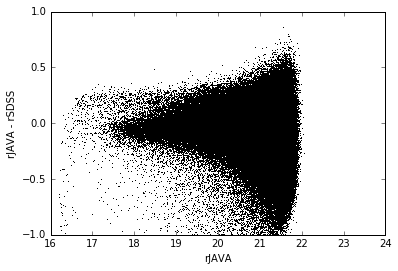

['mask_flags_iJAVA', 'dm_j0660', 'J0861', 'flags_aper3_worstpsf_J0378', 'fwhm', 'cstar', 'flags_aper3_worstpsf_J0515', 'mag_auto_r', 'mask_flags_J0515', 'single_detect_J0395', 'uJAVA', 'dm', 'single_detect_zJAVA', 'flags_aper3_gauss_J0515', 'gJAVA', 'norm_wmap_val_J0378', 'J0378', 'norm_wmap_val_rJAVA', 'single_detect_J0515', 'flags_aper3_gauss_iJAVA', 'flags_aper3_worstpsf_J0660', 'flag_J0430', 'rJAVA', 'flag_uJAVA', 'flags_aper3_worstpsf_J0861', 'elgcand', 'mask_flags_J0660', 'J0515', 'flags_aper3_worstpsf_J0410', 'mask_flags_gJAVA', 'mask_flags_J0861', 'filename', 'single_detect_gJAVA', 'norm_wmap_val_iJAVA', 'flags_aper3_gauss_J0660', 'single_detect_uJAVA', 'err_dm', 'mask_flags_uJAVA', 'norm_wmap_val_J0515', 'flags_aper3_gauss_J0861', 'zSDSS', 'kron_rad', 'XY_IMAGE', 'mask_flags_J0378', 'flag_J0410', 'ids', 'dm_j0660_err', 'single_detect_J0430', 'flags_aper3_worstpsf_J0395', 'flags_aper3_gauss_zJAVA', 'flag_J0395', 'flags_aper3_gauss_uJAVA', 'single_detect_iJAVA', 'mask_flags_J039

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(elg_cand['rJAVA'][:,0],elg_cand['rJAVA'][:,0] - elg_cand['rSDSS'][:,0],'k,')
plt.ylim([-1,1])
plt.xlim([16,24])
plt.xlabel('rJAVA')
plt.ylabel('rJAVA - rSDSS')

plt.show()

print elg_cand.keys()


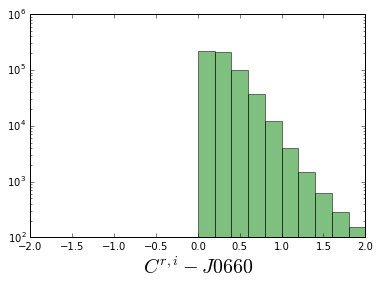

In [6]:
plt.hist(elg_cand['dm_j0660'], bins=20, color='green', alpha=0.5,range=[-2,2])


plt.xlabel(r'$C^{r,i} - J0660$',fontsize=20)
plt.xlim([-2,2])
plt.legend()
plt.yscale('log', nonposy='clip')



In [7]:

# Choose which base catalogue to use when constructing the dataset
#dcat = gal_jplus
suff = 'SDSS'

dm = mtools.gen_3fm(gal_jplus['J0660'][:,0],  
                    gal_jplus['r'+suff][:,0], gal_jplus['g'+suff][:,0], 
                    Broad_NoLineName='gSDSS')

mask = ((dm > 0) & 
        (gal_jplus['g'+suff][:,0] > 20) &
        (gal_jplus['mask_flags_J0660'] == 0) &
        (gal_jplus['single_detect_J0660'] != 0) &
        (1./gal_jplus['J0660'][:,1] > 3))

dcat = jplus.tools.select_object(gal_jplus, mask)

print 'Total number of J-PLUS objects for cross-matches: %d'%len(dcat['tile_id'])


Total number of J-PLUS objects for cross-matches: 835757


In [8]:
print 'Loading 3D-HST and DEEP2'
# Loading 3D-HST and DEEP2 DR4 data

hstdata = hst.select_3DHST_z(0,5)#,LineName='Ha_flux',LineMin=0.001)
nhst = len(hstdata['ra'])
hst_coords = np.zeros([nhst,2])

for i in range(nhst):
    hst_coords[i,:] = [hstdata['ra'][i],hstdata['dec'][i]]
hstdata['coords'] = hst_coords

deep2_data = '/home/CEFCA/aaorsi/work/elg_jplus/spec/deep2/dr4/zcat.deep2.dr4.fits'
deep2 = fits.open(deep2_data)[1].data


# XMatch with 3DHST
print 'xmatch with 3DHST'
d,ind = jplus.tools.crossmatch_angular(dcat['coords'],hstdata['coords'],max_distance=3e-3)
m = ((d != np.inf))

jhst0 = jplus.tools.select_object(dcat, m)
jhst0['z_spec'] = hstdata['z'][ind[m]]

elg_hst =  (
            (((jhst0['z_spec'] > z_ha[0])   & (jhst0['z_spec'] < z_ha[1]))   |
           ((jhst0['z_spec'] > z_hb[0])   & (jhst0['z_spec'] < z_hb[1]))   |
           ((jhst0['z_spec'] > z_oiii[0]) & (jhst0['z_spec'] < z_oiii[1])) |
           ((jhst0['z_spec'] > z_oii[0])  & (jhst0['z_spec'] < z_oii[1]))))

jhst = jplus.tools.select_object(jhst0, elg_hst)
nhst = len(jhst['z_spec'])
jhst['idd'] = np.arange(nhst)


# xmatch with DEEP2
print 'xmatch with DEEP2'
d2mask = ((deep2['ZQUALITY'] > 2) &  # Select only Deep2 objects with good quality Redshifts
        (deep2['Z'] <= z_ha[1]) |
           ((deep2['Z'] >= z_hb[0])   &   (deep2['Z'] <= z_hb[1]))   |
           ((deep2['Z'] >= z_oiii[0]) &   (deep2['Z'] <= z_oiii[1])) |
           ((deep2['Z'] >= z_oii[0])  &   (deep2['Z'] <= z_oii[1])))
          
          
ndeep2 = len(deep2['RA'][d2mask])
dcoords = np.asarray([[deep2['RA'][d2mask][i], deep2['DEC'][d2mask][i]] for i in range(ndeep2)])
d,ind = jplus.tools.crossmatch_angular(dcat['coords'],dcoords,max_distance=3e-3)
m = ((d != np.inf))

jdeep2 = jplus.tools.select_object(dcat, m )
jdeep2['z_spec'] = deep2['Z'][d2mask][ind[m]]
ndeep2 = len(jdeep2['z_spec'])  
#jdeep2['idd'] = np.arange(ndeep2)
print jdeep2['z_spec']
print jhst['z_spec']
print 'Done loading data!'

Loading 3D-HST and DEEP2
xmatch with 3DHST
xmatch with DEEP2
[ 0.36878949  0.35519993  0.35306874  0.35397986  0.78390485  0.36602893
  0.35424313  0.33044887  0.3557249   0.33357745  0.34784138  0.30875733
  0.36581108  0.33210975  0.79243684  0.3544631   0.34772989  0.33541748
  0.33146477  0.7512027   0.35905191  0.35327309  0.76720405  0.35563126
  0.35462806  0.37544972  0.37119287  0.36932802  0.35028651  0.37607512
  0.35473329  0.75847417  0.35749072  0.78144133  0.78680694  0.76222193
  0.34943727  0.75763071  0.37129629  0.35798618  0.35727757  0.3461816
  0.75723845  0.75834364  0.76442438  0.77820718  0.37433416  0.35375842
  0.32584473  0.76971471  0.36167777  0.79557502  0.35441938  0.77220601
  0.36984107  0.3500154   0.35549825  0.36261395  0.37019995  0.35139999
  0.75195217  0.36455217  0.3547315   0.35112539]
[ 0.3438   0.37575  0.37026]
Done loading data!


Reading and performing cross-match with ALHAMBRA objects
['F830W', 'F814W', 'F799W', 'F644W', 'F892W', 'F954W', 'F582W', 'zphoto', 'F427W', 'F675W', 'F551W', 'F768W', 'F365W', 'F706W', 'F458W', 'cstar', 'F489W', 'F861W', 'F923W', 'coords', 'F613W', 'F396W', 'F737W', 'F520W']
Cross match between Alhambra and J-PLUS results in 882 objects
154


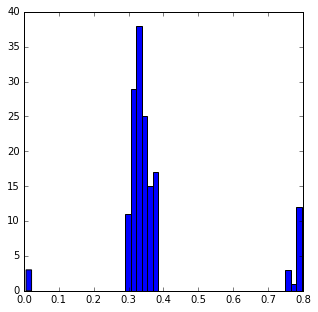

In [9]:
print 'Reading and performing cross-match with ALHAMBRA objects'
import deepdish as dd
AlhambraFile = '/home/CEFCA/aaorsi/work/alhambra/Alhambra.hdf5'

alh = dd.io.load(AlhambraFile)
print alh.keys()


alh_d,alh_ind = jplus.tools.crossmatch_angular(dcat['coords'],alh['coords'],max_distance=3e-4)
alh_m = ((alh_d != np.inf))

j_alh = jplus.tools.select_object(dcat, alh_m)
print 'Cross match between Alhambra and J-PLUS results in %ld objects' % len(j_alh['tile_id'])
j_alh['z_spec'] = alh['zphoto'][alh_ind[alh_m]]

plt.rcParams['figure.figsize'] = 5, 5

mask_elgs =  (
            (((j_alh['z_spec'] > z_ha[0])   & (j_alh['z_spec'] < z_ha[1]))   |
           ((j_alh['z_spec'] > z_hb[0])   & (j_alh['z_spec'] < z_hb[1]))   |
           ((j_alh['z_spec'] > z_oiii[0]) & (j_alh['z_spec'] < z_oiii[1])) |
           ((j_alh['z_spec'] > z_oii[0])  & (j_alh['z_spec'] < z_oii[1]))))


plt.hist(j_alh['z_spec'][mask_elgs], bins=50)
nalh = len(j_alh['z_spec'][mask_elgs])

j_alhambra = jplus.tools.select_object(j_alh, mask_elgs)

print nalh


j-plus [INFO]: Fetching SDSS objects
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/sdss_galaxies_aperMags_magmax21.0.h5


Cross-match of SDSS phot with J-PLUS ...
xmatch catalogue contains 25083 galaxies
2379


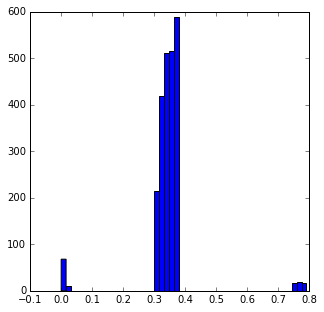

In [10]:
# Loading SDSS data

gal_sdss_spec = jplus.datasets.fetch_sdss_objects(mag_type="aperMags",overwrite=False,mag_limit=[16,21], extinction=False,
                                                          clean = True, nchunks = 5, spectroscopic=True, 
                                                    casjobs=True, object_name="galaxies")

print 'Cross-match of SDSS phot with J-PLUS ...'
d,ind = jplus.tools.crossmatch_angular(dcat['coords'],gal_sdss_spec['coords'],max_distance=3e-4)
m = ((d != np.inf))

j_spec = jplus.tools.select_object(dcat, m)

        
print 'xmatch catalogue contains %ld galaxies' % len(j_spec['tile_id'])
        #jplus['in_sdss'] = m
        # Adding SDSS magnitudes
j_spec['rSDSS'] = gal_sdss_spec['rSDSS'][ind[m]]
j_spec['iSDSS'] = gal_sdss_spec['iSDSS'][ind[m]]
j_spec['uSDSS'] = gal_sdss_spec['uSDSS'][ind[m]]
j_spec['gSDSS'] = gal_sdss_spec['gSDSS'][ind[m]]
j_spec['zSDSS'] = gal_sdss_spec['zSDSS'][ind[m]]
j_spec['z_spec'] = gal_sdss_spec['zspec'][ind[m]]

plt.rcParams['figure.figsize'] = 5, 5

mask_elgs =  (
            (((j_spec['z_spec'] > z_ha[0])   & (j_spec['z_spec'] < z_ha[1]))   |
           ((j_spec['z_spec'] > z_hb[0])   & (j_spec['z_spec'] < z_hb[1]))   |
           ((j_spec['z_spec'] > z_oiii[0]) & (j_spec['z_spec'] < z_oiii[1])) |
           ((j_spec['z_spec'] > z_oii[0])  & (j_spec['z_spec'] < z_oii[1]))))


plt.hist(j_spec['z_spec'][mask_elgs], bins=50)
nsdss = len(j_spec['z_spec'][mask_elgs])

j_sdss = jplus.tools.select_object(j_spec, mask_elgs)

print nsdss


In [11]:
%matplotlib inline
import matplotlib.gridspec as gsc

training_frac = 0.7 # the rest is for testing
ngals_tot = ndeep2 + nhst + nsdss + nalh
print 'Total number of galaxies used in data set: %d'%ngals_tot

dataspec = {}

for key in jdeep2:
    if key == 'date' or key == 'SQL_query' or key == 'filename':
        continue
    value_hst   = jhst[key]
    value_deep2 = jdeep2[key]
    value_sdss  = j_sdss[key]
    value_alh   = j_alhambra[key]
    shape = value_deep2.shape
    ndim = value_deep2.ndim
    dataspec[key] = np.zeros(ngals_tot) if ndim == 1 else np.zeros([ngals_tot, shape[1]])
    dataspec[key][0:ndeep2] = value_deep2
    dataspec[key][ndeep2:ndeep2+nhst] = value_hst   
    dataspec[key][ndeep2+nhst:ndeep2+nhst+nsdss] = value_sdss   
    dataspec[key][ndeep2+nhst+nsdss:] = value_alh   

dataspec['type'] = []
for i in range(ndeep2):
    dataspec['type'].append('DEEP2')
for i in range(nhst):
    dataspec['type'].append('3D-HST')
for i in range(nsdss):
    dataspec['type'].append('SDSS')
for i in range(nalh):
    dataspec['type'].append('Alhambra')
    
dataspec['index'] = np.arange(ndeep2 + nhst+nsdss+nalh)    





Total number of galaxies used in data set: 2600


In [12]:
print 23**2

529


In [13]:
# Plot all dataset
Plot_TrainingSet = False
import matplotlib.pyplot as plt

if Plot_TrainingSet:

    filternames = [ 'J0378','J0395', 'J0410','J0430','J0515', 'J0660',
                   'J0861','uJAVA', 'gJAVA', 'rJAVA', 'iJAVA','zJAVA']
                #  'uSDSS', 'gSDSS', 'rSDSS', 'iSDSS', 'zSDSS']

    sdss_fnames = ['uSDSS', 'gSDSS', 'rSDSS', 'iSDSS', 'zSDSS']
    sdss_mw     = [3543, 4770, 6231, 7625, 9134]

  
    grid = [22,22]
    gs = gsc.GridSpec(grid[0],grid[1])
    gs.update(wspace=0.035, hspace=0.035)

    plt.rcParams['figure.figsize'] = 60, 60

    
    nxm = len(dataspec['tile_id'])
    print 'Number of xmatched ELGs: %ld'%nxm
    dataspec['dm'] = mtools.gen_3fm(dataspec['J0660'][:,0], dataspec['rJAVA'][:,0], 
                              dataspec['iJAVA'][:,0],Broad_NoLineName='iSDSS')

    ix = 0
    iy = 0
    idg = 0

    sortz = np.argsort(dataspec['z_spec'])

    for i0 in range(nxm):
        i = sortz[i0]
        ax= plt.subplot(gs[ix,iy])
        idg = ix + grid[0]*iy
        for fname in filternames:
            filt = jplus.tools.fetch_jplus_filter(fname, quiet=True)
    #        print np.median(filt.wave)
            ww = [filt.avgwave(), filt.avgwave()]
            ff = [dataspec[fname][i,0], dataspec[fname][i,0]]

            ax.plot(ww,ff,'o', color='blue', markersize=10)
            ax.errorbar(ww,ff,yerr= dataspec[fname][i,1], color='blue')


            if fname == 'J0660':# or fname == 'J0378' or fname == 'J0395' or fname=='J0861':
                fwidth = filt.rectwidth()
                ax.fill_between([ww[0] - fwidth/2.,ww[0] + fwidth/2.,ww[0] + fwidth/2.,ww[0] - fwidth/2.],
                            [19,19, 24, 24],facecolor='Grey',alpha=0.2)
        fw = 0   
        if sdss_fnames[0] in dataspec: # if sdss bands exist
            for fname in sdss_fnames:
                filt = jplus.tools.fetch_sdss_filter(fname, quiet=True)
    #        ww = [filt[0,filt[1,:].argmax()],filt[0,filt[1,:].argmax()]]
                ww = [sdss_mw[fw], sdss_mw[fw]]
                fw += 1
                ff = [dataspec[fname][i,0], dataspec[fname][i,0]]
                ax.plot(ww,ff,'o', color='red', markersize=10)
                ax.errorbar(ww,ff,yerr= dataspec[fname][i,1], color='red')

        ax.text(0.3,0.9,r'$z_{\rm spec}=%.2f$'%dataspec['z_spec'][i], transform= ax.transAxes, fontsize=12)
        ax.text(0.3,0.8,r'$\Delta m=%.2f$'%dataspec['dm'][i], transform= ax.transAxes, fontsize=12, color='red')
        ax.text(0.3,0.7,dataspec['type'][i], transform= ax.transAxes, fontsize=12, color='black')
        ax.text(0.1,0.9,'(%d)'%idg, transform=ax.transAxes,fontsize=15)
        ax.set_ylim([25, 17.99])
        ax.set_xlim([3000, 8999])
        if ix != grid[0]-1:
            ax.set_xticklabels([])
        if iy >0:
            ax.set_yticklabels([])
        ix +=1
        if ix == grid[0]:
            ix = 0
            iy += 1

    plt.show()        



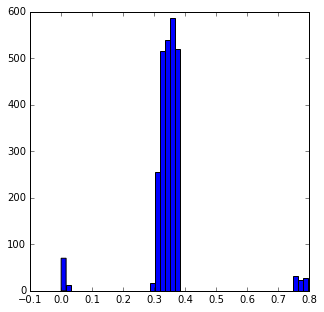

In [14]:
plt.rcParams['figure.figsize'] = 5, 5
plt.hist(dataspec['z_spec'],bins=50)
plt.show()

In [15]:
# Classifying the full set of galaxies
dataspec['class'] = []
for i in range(ngals_tot):
    zp = dataspec['z_spec'][i]
    if zp < z_ha[1]:
        dataspec['class'].append('Halpha')
#    elif (zp > z_ha[1]) and (zp < z_oiii[1]):
#        dataspec['class'].append('OIII')
#    elif (zp > z_oiii[1]) and (zp < z_hb[1]):
#        dataspec['class'].append('Hbeta')
    elif (zp > z_ha[1]) and (zp < z_hb[1]):
        dataspec['class'].append('OIII+Hbeta')
    elif (zp > 0.5):
        dataspec['class'].append('OII')
    else:
        print 'something is wrong with this redshift: %f'%zp

m_z0  = np.asarray(dataspec['class']) == 'Halpha'
m_zp3 = np.asarray(dataspec['class']) == 'OIII+Hbeta'
#m_zp35 = np.asarray(dataspec['class']) == 'Hbeta'
m_zp7 = np.asarray(dataspec['class']) == 'OII'

nz0  = len(dataspec['z_spec'][m_z0])
nzp3 = len(dataspec['z_spec'][m_zp3])  
#nzp35 = len(dataspec['z_spec'][m_zp35])  
nzp7 = len(dataspec['z_spec'][m_zp7])
print 'Number of Halpha emitters: %ld' % nz0
print 'Number of OIII+Hbeta emitters: %ld' % nzp3       
#print 'Number of Hbeta emitters: %ld' % nzp35
print 'Number of OII emitters: %ld' % nzp7


Number of Halpha emitters: 82
Number of OIII+Hbeta emitters: 2434
Number of OII emitters: 84


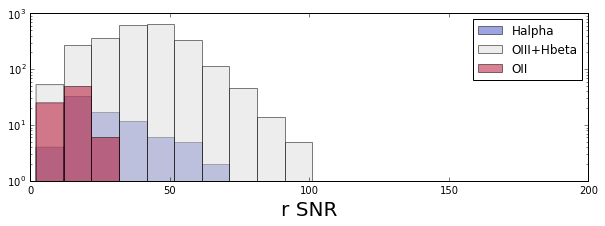

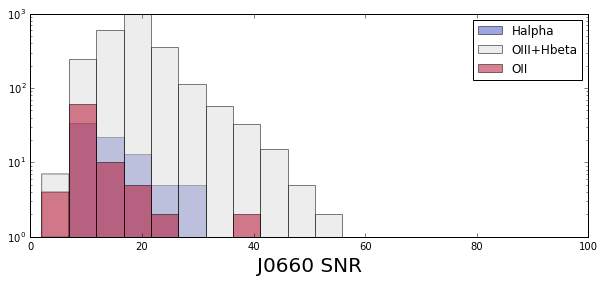

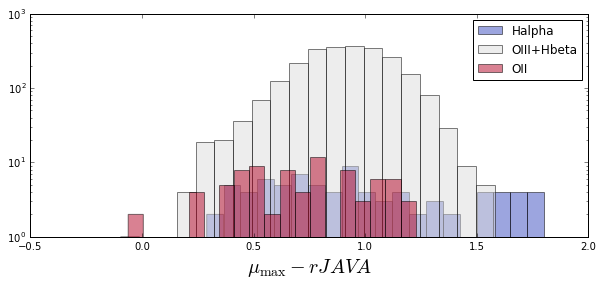

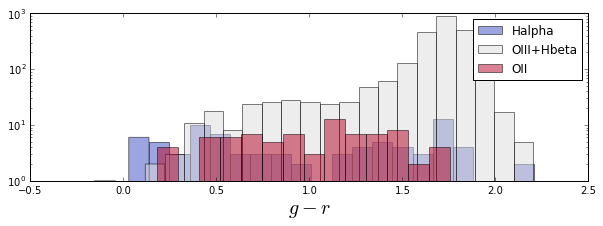

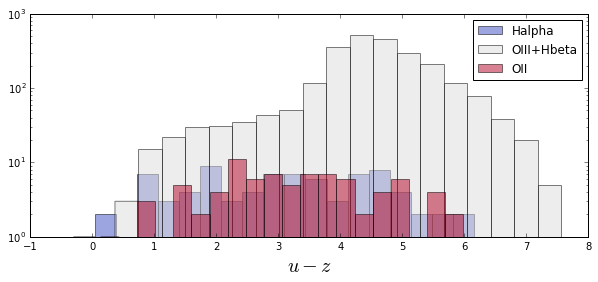

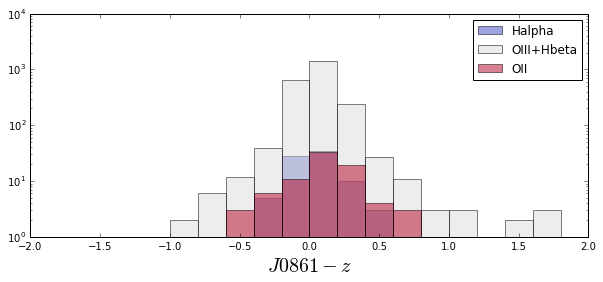

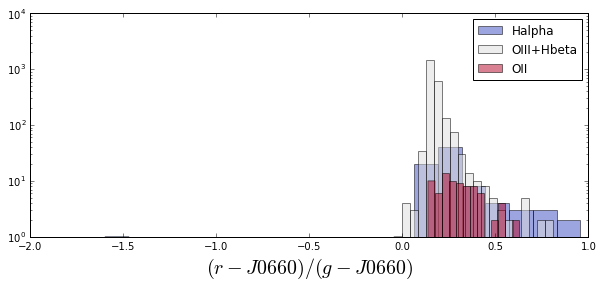

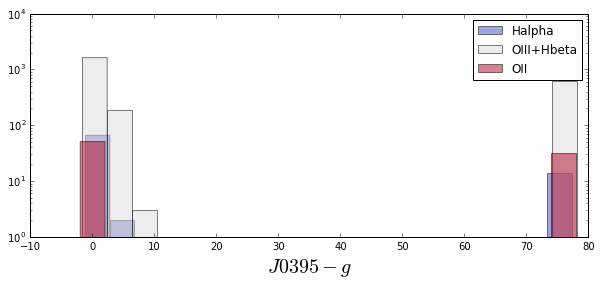

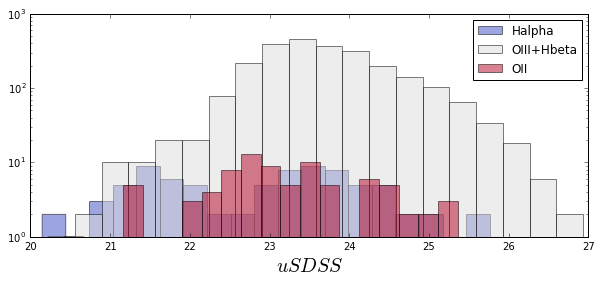

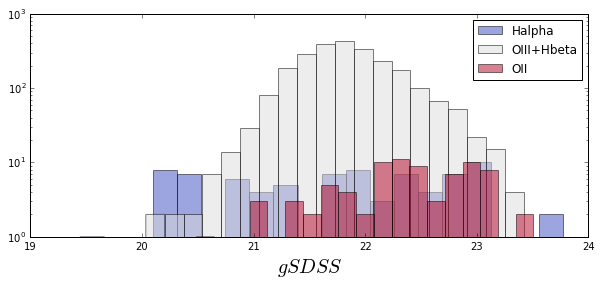

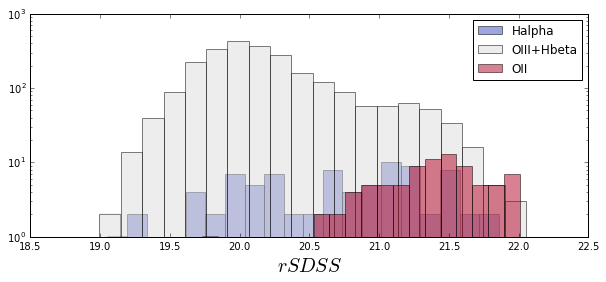

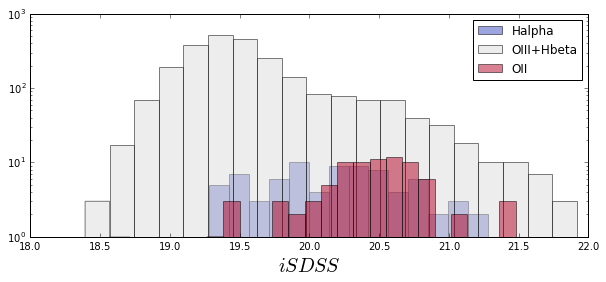

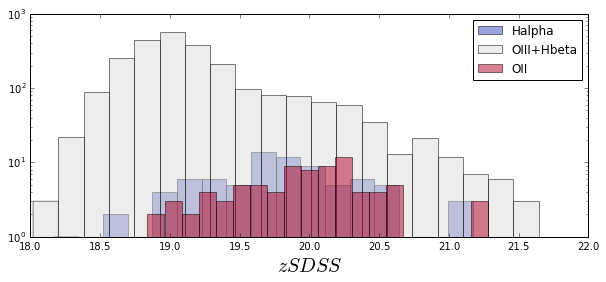

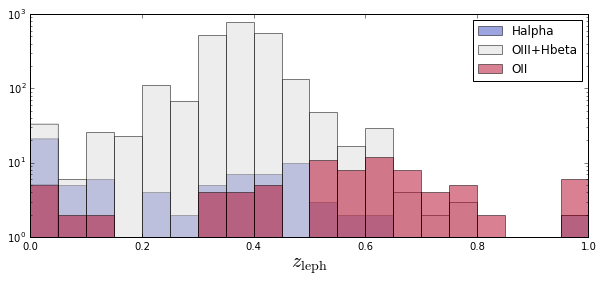

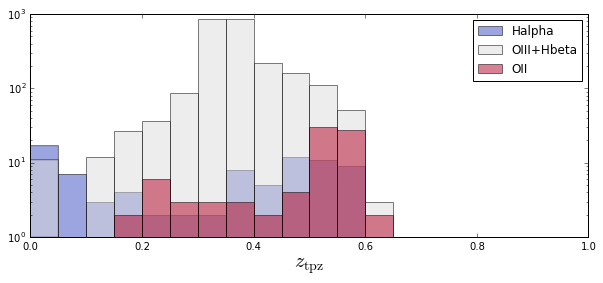

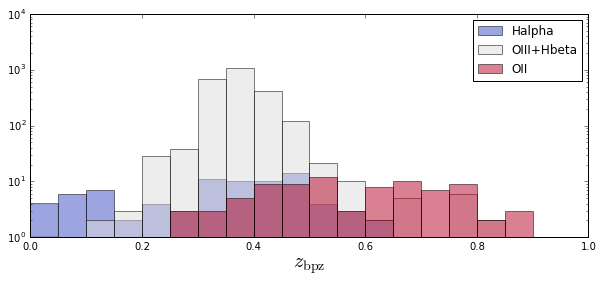

In [16]:
# Plot distribution of some features for all classes

snr = 1./dataspec['rSDSS'][:,1]
snr_ha = 1./dataspec['J0660'][:,1]

#classes_names = ['Halpha', 'OIII', 'Hbeta','OII']
classes_names = ['Halpha', 'OIII+Hbeta','OII']
colors = plt.cm.coolwarm(np.linspace(0,1,len(classes_names)))
iic = 0
plt.figure(1,figsize=(10,3))

for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    plt.hist(snr[mask], bins=20, color=colors[iic], alpha=0.5, label=ic, range=[2,200])
    iic += 1
    
plt.xlabel('r SNR',fontsize=20)
plt.xlim([0,200])
plt.legend()
plt.yscale('log', nonposy='clip')

plt.figure(2,figsize=(10,4))

iic= 0
for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    plt.hist(snr_ha[mask], bins=20, color=colors[iic], alpha=0.5, label=ic, range=[2,100])
    iic += 1

plt.xlabel('J0660 SNR',fontsize=20)
plt.xlim([0,100])
plt.legend()
plt.yscale('log', nonposy='clip')


plt.figure(3,figsize=(10,4))

iic= 0
for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    plt.hist(dataspec['mu_max_r'][mask]-dataspec['rJAVA'][mask,0], bins=20, color=colors[iic], alpha=0.5, label=ic)
    iic += 1

plt.xlabel(r'$\mu_{\rm max}- rJAVA$',fontsize=20)
#plt.xlim([0,100])
plt.legend()
plt.yscale('log', nonposy='clip')

#plt.figure(4,figsize=(10,4))
#suff = 'SDSS'

#iic= 0
#for ic in classes_names:
#    mask = np.asarray(dataspec['class']) == ic
#    plt.hist(dataspec['dm_j0660'][mask], bins=20, color=colors[iic], alpha=0.5, label=ic,range=[0,2])
#    iic += 1

#plt.xlabel(r'$C^{r,g} - J0660$',fontsize=20)
#plt.xlim([-0.5,2])
#plt.legend()
#plt.yscale('log', nonposy='clip')

plt.figure(5,figsize=(10,3))
suff = 'SDSS'

iic= 0
for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    plt.hist(dataspec['g'+suff][mask,0] - dataspec['r'+suff][mask,0], bins=20, color=colors[iic], alpha=0.5, label=ic)#,range=[0,2])
    iic += 1

plt.xlabel(r'$g-r$',fontsize=20)
#plt.xlim([-0.5,2])
plt.legend()
plt.yscale('log', nonposy='clip')

plt.figure(6,figsize=(10,4))
suff = 'SDSS'

iic= 0
for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    plt.hist(dataspec['u'+suff][mask,0] - dataspec['z'+suff][mask,0], bins=20, color=colors[iic], alpha=0.5, label=ic)#,range=[0,2])
    iic += 1

plt.xlabel(r'$u-z$',fontsize=20)
#plt.xlim([-0.5,2])
plt.legend()
plt.yscale('log', nonposy='clip')

plt.figure(7,figsize=(10,4))
suff = 'SDSS'

iic= 0
for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    plt.hist(dataspec['J0861'][mask,0] - dataspec['z'+suff][mask,0], bins=20, color=colors[iic], alpha=0.5, label=ic,range=[-2,2])
    iic += 1

plt.xlabel(r'$J0861-z$',fontsize=20)
#plt.xlim([-0.5,2])
plt.legend()
plt.yscale('log', nonposy='clip')

plt.figure(8,figsize=(10,4))
suff = 'SDSS'

iic= 0
for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    right_col = dataspec['r'+suff][mask,0]-dataspec['J0660'][mask,0]
    left_col = dataspec['g'+suff][mask,0]-dataspec['J0660'][mask,0]
    plt.hist(right_col/left_col, bins=20, color=colors[iic], alpha=0.5, label=ic)
    iic += 1

plt.xlabel(r'$(r-J0660)/(g-J0660)$',fontsize=20)
#plt.xlim([-0.5,2])
plt.legend()
plt.yscale('log', nonposy='clip')

plt.figure(9,figsize=(10,4))
suff = 'SDSS'

iic= 0
for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    plt.hist(dataspec['J0395'][mask,0] - dataspec['g'+suff][mask,0], bins=20, color=colors[iic], alpha=0.5, label=ic)
    iic += 1

plt.xlabel(r'$J0395-g$',fontsize=20)
#plt.xlim([-0.5,2])
plt.legend()
plt.yscale('log', nonposy='clip')



bb = ['u','g','r','i','z']

for band in bb:
    plt.figure(band,figsize=(10,4))
    suff = 'SDSS'

    iic= 0
    for ic in classes_names:
        mask = np.asarray(dataspec['class']) == ic
        plt.hist(dataspec[band+suff][mask,0] , bins=20, color=colors[iic], alpha=0.5, label=ic)
        iic += 1

    plt.xlabel(r'$%s%s$'%(band,suff),fontsize=20)
    #plt.xlim([-0.5,2])
    plt.legend()
    plt.yscale('log', nonposy='clip')



pzarr = ['leph', 'tpz', 'bpz']    

for pz in pzarr:
    plt.figure(pz,figsize=(10,4))
    suff = 'SDSS'

    iic= 0
    for ic in classes_names:
        mask = np.asarray(dataspec['class']) == ic
        plt.hist(dataspec['photoz_'+pz][mask], bins=20, color=colors[iic], alpha=0.5, label=ic, range=[0,1])
        iic += 1

    plt.xlabel(r'$z_{\rm %s}$'%pz,fontsize=20)
    #plt.xlim([-0.5,2])
    plt.legend()
    plt.yscale('log', nonposy='clip')

    

In [17]:
print dataspec['mu_max_r'][0]
print dataspec.keys()
#dataspec['cstar']

21.8654957
['flags_aper3_gauss_uJAVA', 'J0861', 'flags_aper3_worstpsf_J0378', 'fwhm', 'cstar', 'flags_aper3_worstpsf_J0515', 'mag_auto_r', 'flags_aper3_gauss_iJAVA', 'mask_flags_J0515', 'single_detect_J0395', 'uJAVA', 'dm', 'single_detect_zJAVA', 'z_spec', 'flags_aper3_gauss_J0515', 'gJAVA', 'norm_wmap_val_J0378', 'J0378', 'flag_J0430', 'single_detect_J0515', 'coords', 'norm_wmap_val_rJAVA', 'flags_aper3_gauss_zJAVA', 'flag_uJAVA', 'flags_aper3_worstpsf_J0861', 'mask_flags_J0660', 'J0515', 'flags_aper3_worstpsf_J0410', 'mask_flags_gJAVA', 'index', 'flags_aper3_worstpsf_J0430', 'single_detect_gJAVA', 'norm_wmap_val_iJAVA', 'flags_aper3_gauss_J0660', 'single_detect_uJAVA', 'err_dm', 'mask_flags_uJAVA', 'norm_wmap_val_J0515', 'flags_aper3_gauss_J0861', 'zSDSS', 'kron_rad', 'XY_IMAGE', 'mask_flags_J0378', 'flag_J0410', 'flags_aper3_gauss_J0378', 'single_detect_J0430', 'flags_aper3_worstpsf_J0395', 'rJAVA', 'flag_J0395', 'mask_flags_iJAVA', 'single_detect_iJAVA', 'mask_flags_J0395', 'flag_J

In [18]:
# This function retrieves a features list for a single object.

def prepare_sample(data, index, sample_error = True, sample_type = 'All_Mags', filters='J-PLUS'):
    
    BBNames = ['u','g','r','i','z']
    
    suff = 'JAVA' if filters == 'J-PLUS' else 'SDSS'
    
    filternames = [ 'J0378','J0395', 'J0410','J0430','J0515', 'J0660',
                   'J0861','u'+suff, 'g'+suff, 'r'+suff, 'i'+suff,'z'+suff]
        
        
    
    flist = [] # filterslist
    ferrlist = []
    nfilters = len(filternames)
    amplitude = np.random.normal(0, 2.0) # amplitude scaling change 
    for ff in filternames:
        if sample_error:
            flist.append(np.random.normal(data[ff][index,0], data[ff][index,1]) + amplitude)  # errors distribute like a gaussian (?)
        else:
            flist.append(data[ff][index,0])
        ferrlist.append(data[ff][index,1])
    
    sample = [] # The sample's features
    
    dm_J0515 = mtools.gen_3fm(data['J0515'][index,0], data['g'+suff][index,0], 
                          data['r'+suff][index,0],Broad_NoLineName='rSDSS', LineFilterName='J0515', 
                          Broad_LineName='gSDSS')
#    err_dm_J0515 = mtools.gen_3fm_err(data['J0515'][index,0], data['J0515'][index,1], data['g'+suff][index,0], 
#                                      data['g'+suff][index,1], data['r'+suff][index,0], data['r'+suff][index,1],
#                                      Broad_NoLineName='rSDSS')


    dm_J0378 = mtools.gen_3fm(data['J0378'][index,0], data['u'+suff][index,0], 
                          data['g'+suff][index,0],Broad_NoLineName='gSDSS', LineFilterName='J0378', 
                              Broad_LineName='uJAVA')
#    err_dm_J0378 = mtools.gen_3fm_err(data['J0378'][index,0], data['J0378'][index,1], data['u'+suff][index,0], 
#                                      data['u'+suff][index,1],data['g'+suff][index,0], data['g'+suff][index,1],
#                                      Broad_NoLineName='gSDSS')

    dm_J0861 = mtools.gen_3fm(data['J0861'][index,0], data['z'+suff][index,0], 
                          data['i'+suff][index,0],Broad_NoLineName='iSDSS', 
                          LineFilterName='J0861', Broad_LineName='zSDSS')

#    err_dm_J0861 = mtools.gen_3fm_err(data['J0861'][index,0], data['J0861'][index,1], data['z'+suff][index,0], 
#                          data['z'+suff][index,1],data['i'+suff][index,0], data['i'+suff][index,1],
#                          Broad_NoLineName='iSDSS')

#    dm_J0660 = mtools.gen_3fm(data['J0660'][index,0], data['r'+suff][index,0], 
#                          data['g'+suff][index,0],Broad_NoLineName='gSDSS', 
#                          LineFilterName='J0660', Broad_LineName='rSDSS')

#    err_dm_J0660 = mtools.gen_3fm_err(data['J0660'][index,0], data['J0660'][index,1], data['r'+suff][index,0], 
#                          data['r'+suff][index,1],data['g'+suff][index,0], data['g'+suff][index,1],
#                          Broad_NoLineName='gSDSS')

    
    # Here I should get creative
    if sample_type == 'All_Mags':
        sample = flist # All individual filters
    if sample_type == 'All_Mags_mumax':
        for i in range(nfilters):
            sample.append(flist[i])
        sample.append(data['mu_max_r'][index] - data['rJAVA'][index,0])
        #sample.append(data['cstar'][index])
#        sample.append(data['pz_bpz'][index])
    if sample_type == 'Colors':
        for i in range(nfilters):
            sample.append(flist[i])
            for j in range(nfilters):
                if i != j:
                    sample.append(flist[i] - flist[j])
                   
    if sample_type == 'All':
        for i in range(nfilters):
            sample.append(flist[i])
        sample.append(data['mu_max_r'][index])
        #sample.append(data['cstar'][index])
        sample.append(data['pz_bpz'][index])
        for i in range(nfilters):
            sample.append(flist[i])
            for j in range(nfilters):
                if i != j:
                    sample.append(flist[i] - flist[j]) 
    if sample_type == 'dm':
        # Delta-m and SNR of deltaMs...
        sample=[dm_J0515, #1./err_dm_J0515,
                dm_J0378, #1./err_dm_J0378,
                dm_J0861#, 1./err_dm_J0861
               ] #dm_J0660#, 1./err_dm_J0660 
                 #data['dm'][index],data['err_dm'][index]
                 #]
        sample.append(data['mu_max_r'][index] - data['rJAVA'][index,0])
        
        #for ff in BBNames:
        #    sample.append(np.random.normal(data[ff+suff][index,0], data[ff+suff][index,1])
        #    if sample_error else data[ff+suff][index,0])
        
        #u-g
        #sample.append(np.random.normal(data['u'+suff][index,0], data['u'+suff][index,1])-
        #              np.random.normal(data['g'+suff][index,0], data['g'+suff][index,1])
        #              if sample_error else data['u'+suff][index,0]-data['g'+suff][index,0])
        #g-r
        sample.append(np.random.normal(data['g'+suff][index,0], data['g'+suff][index,1])-
                      np.random.normal(data['r'+suff][index,0], data['r'+suff][index,1])
                      if sample_error else data['g'+suff][index,0]-data['r'+suff][index,0])

        #r-i
        sample.append(np.random.normal(data['r'+suff][index,0], data['r'+suff][index,1])-
                      np.random.normal(data['i'+suff][index,0], data['i'+suff][index,1])
                      if sample_error else data['r'+suff][index,0]-data['i'+suff][index,0])

        #i-z
        sample.append(np.random.normal(data['i'+suff][index,0], data['i'+suff][index,1])-
                      np.random.normal(data['z'+suff][index,0], data['z'+suff][index,1])
                      if sample_error else data['i'+suff][index,0]-data['z'+suff][index,0])

        #u-z
        #sample.append(np.random.normal(data['u'+suff][index,0], data['u'+suff][index,1])-
        #             np.random.normal(data['z'+suff][index,0], data['z'+suff][index,1])
        #              if sample_error else data['u'+suff][index,0]-data['z'+suff][index,0])
        
        #r-z
        sample.append(np.random.normal(data['r'+suff][index,0], data['r'+suff][index,1])-
                     np.random.normal(data['z'+suff][index,0], data['z'+suff][index,1])
                      if sample_error else data['r'+suff][index,0]-data['z'+suff][index,0])
        
        
        #SNR in r-band
        sample.append(1./data['r'+suff][index,1])
        #SNR in J0660 band
        #sample.append(1./data['J0660'][index,1])
        
        # r-band
        sample.append(np.random.normal(data['r'+suff][index,0] if sample_error else data['r'+suff][index,0]))
        #g-band
        #sample.append(np.random.normal(data['g'+suff][index,0] if sample_error else data['g'+suff][index,0]))
        
        
        
    return sample



In [19]:
Compute_Dataset = False   # if False it reads a dataset from a file

Training_set_class_frac = .8 # a fraction X of the less abundant determines the number of objects per class in the training set.
Sampling_errors         = 1  # Each training galaxy is resampled X times using its errors

# Set only one of these to True
Sample_Small_Only = False       # If True, it will resample only the class with the smallest sample
Sample_Balancing  = True        # All classes are resampled but the end result is balanced
UseFixedNum       = False       # Use a fixed number of objects per class

# indices of different categories of objects
id_z0   = dataspec['index'][m_z0] 
id_z0p3 = dataspec['index'][m_zp3]
#id_z0p35 = dataspec['index'][m_zp35]
id_z0p7 = dataspec['index'][m_zp7]

#nzarr = [nz0, nzp3, nzp35, nzp7]
nzarr = [nz0, nzp3, nzp7]
min_class = np.min(nzarr)
id_min    = np.argmin(nzarr)
id_max    = np.argmax(nzarr)

MaxClass = Sampling_errors * nzarr[id_max] 

if Sample_Balancing:
    print 'MaxClass = %d'%MaxClass

balance_factors= [int((MaxClass+0.)/i) for i in nzarr]

if UseFixedNum:
    numperclass = int(min_class*Training_set_class_frac)
    print 'number of objects in training set per class before sampling errors: %d'%numperclass
    print 'number of objects left for validation: %d'%(ngals_tot-numperclass*3)
    
# Randomised lists:
ran_idz0 = np.random.permutation(id_z0)
ran_idz0p3 = np.random.permutation(id_z0p3)    
#ran_idz0p35 = np.random.permutation(id_z0p35)    
ran_idz0p7 = np.random.permutation(id_z0p7)

#id_arr = [ran_idz0, ran_idz0p3, ran_idz0p35, ran_idz0p7]
id_arr = [ran_idz0, ran_idz0p3, ran_idz0p7]

training_features = []
training_class    = []

sample_type='dm'
filterset = 'SDSS'

if Compute_Dataset:

    DoSampling = True if Sampling_errors >= 1 else False

    iid = 0
    for id_obj in id_arr:
        nid = numperclass if UseFixedNum else int(len(id_obj)*Training_set_class_frac)

        if Sample_Small_Only:
            DoSampling = True if (Sampling_errors >= 1) and (iid == id_min) else False
            Serr = 1
        else:
            Serr = Sampling_errors

        if Sample_Balancing:
            DoSampling = True
            Serr = balance_factors[iid]
            print 'Balancing sample %d with resampling %d'% (iid, Serr)
        iclass = 0
        for i in range(nid):
            for j in range(Serr):
                training_features.append(prepare_sample(dataspec, id_obj[i], sample_error=DoSampling, 
                                                        sample_type=sample_type, filters=filterset))
                training_class.append(dataspec['class'][id_obj[i]])
                iclass += 1
        iid += 1
        print 'Number of elements in class %d: %d'%(iid, iclass)


    if Training_set_class_frac < 1:    # if == 1 then CV is used instead
        validate_features = []
        validate_class    = []

        for id_obj in id_arr:
            n0id = numperclass if UseFixedNum else int(len(id_obj)*Training_set_class_frac)
            nid = len(id_obj)

            for i in range(n0id, nid):
                validate_features.append(prepare_sample(dataspec, id_obj[i], sample_error=False, 
                                                        sample_type=sample_type, filters=filterset))
                validate_class.append(dataspec['class'][id_obj[i]])


    # Save dataset to a file
    dataset = {'tfeatures':training_features,
                   'tclass'   :training_class,
                   'vfeatures':validate_features,
                   'vclass'   :validate_class}

    with open('dataset.data','wb') as outfile:
        pickle.dump(dataset,outfile,protocol=pickle.HIGHEST_PROTOCOL)  

else:
    dataset = pickle.load(open('dataset.data'))
    training_features = dataset['tfeatures']
    training_class    = dataset['tclass']
    validate_features = dataset['vfeatures']
    validate_class    = dataset['vclass']
    

print 'number of objects in training set: %ld'%len(training_features)        
#for i in range(len(training_features)):
#    print training_features[i], training_class[i]
    
print 'Number of features: %ld' % len(training_features[0])
ntrain = len(training_features)     
nfeat = len(training_features[0])



MaxClass = 2434
number of objects in training set: 5708
Number of features: 10


In [20]:
#Taken from 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [78]:
#mlcolors[index]
def summary_performance_plot(index,precision, recall, fscore, color, cnum, ctype, name,  gs, figname='summary', ylim = [.0, 1.1]):
    
    
    ax = plt.subplot(gs[0])
    ax.plot(cnum, precision,'o-', label=name, color=color)
    ax.grid(True)
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(ctype)
    ax.set_title('Precision')
    ax.set_xlim([-0.25,2.25])
    ax.set_ylim(ylim)
    ax.legend(loc='lower left',fontsize=10)
    
    ax = plt.subplot(gs[1])
    ax.plot(cnum, recall,'o-', label=name, color=color)
    ax.grid(True)
    ax.set_xticks([0,1,2, 3])
    ax.set_xticklabels(ctype)
    ax.set_title('Recall')
    ax.set_xlim([-0.25,2.25])
    ax.set_ylim(ylim)
    ax.set_yticklabels([])
    if index == 0:
        ax.text(0.5,1.15, figname, fontsize=20, transform=ax.transAxes)
    
  #  ax.legend(loc='lower left',fontsize=10)
    
    ax = plt.subplot(gs[2])
    ax.plot(cnum, fscore,'o-', label=name, color=color)
    ax.grid(True)
    ax.set_xticks([0,1,2, 3])
    ax.set_xticklabels(ctype)
    ax.set_title('Fscore')
    ax.set_xlim([-0.25,2.25])
    ax.set_ylim(ylim)
    ax.set_yticklabels([])
   # ax.legend(loc='lower left',fontsize=10)
    
    return
    

In [79]:
# Run ML
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler 
from sklearn import tree
from sklearn import svm 

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF 

from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

if Training_set_class_frac == 1: # Do the splitting automatically instead of defined as above
     training_features, validate_features, training_class, validate_class = train_test_split(
     training_features, training_class, test_size=0.4, random_state=0)

Scaledata = True

if Scaledata:
    scaler = StandardScaler()
    scaler.fit(training_features)
    Traindata = scaler.transform(training_features)
    Testdata  = scaler.transform(validate_features)
else:
    Traindata = training_features
    Testdata  = validate_features

0.01
0.016681005372
0.0278255940221
0.0464158883361
0.0774263682681
0.129154966501
0.215443469003
0.35938136638
0.599484250319
1.0
MLP alpha=0.0100000
MLP alpha=0.0166810
MLP alpha=0.0278256
MLP alpha=0.0464159
MLP alpha=0.0774264
MLP alpha=0.1291550
MLP alpha=0.2154435
MLP alpha=0.3593814
MLP alpha=0.5994843
MLP alpha=1.0000000


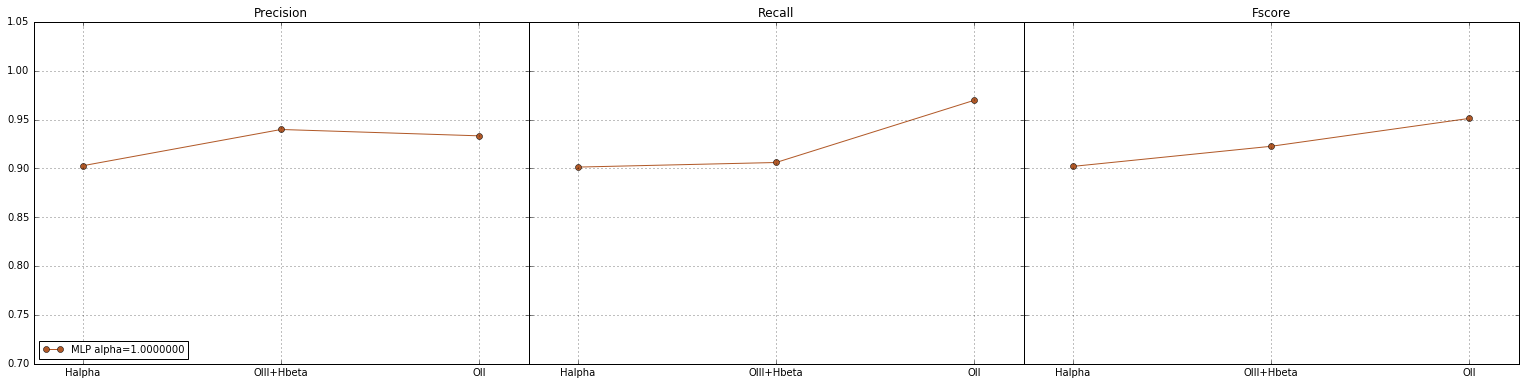

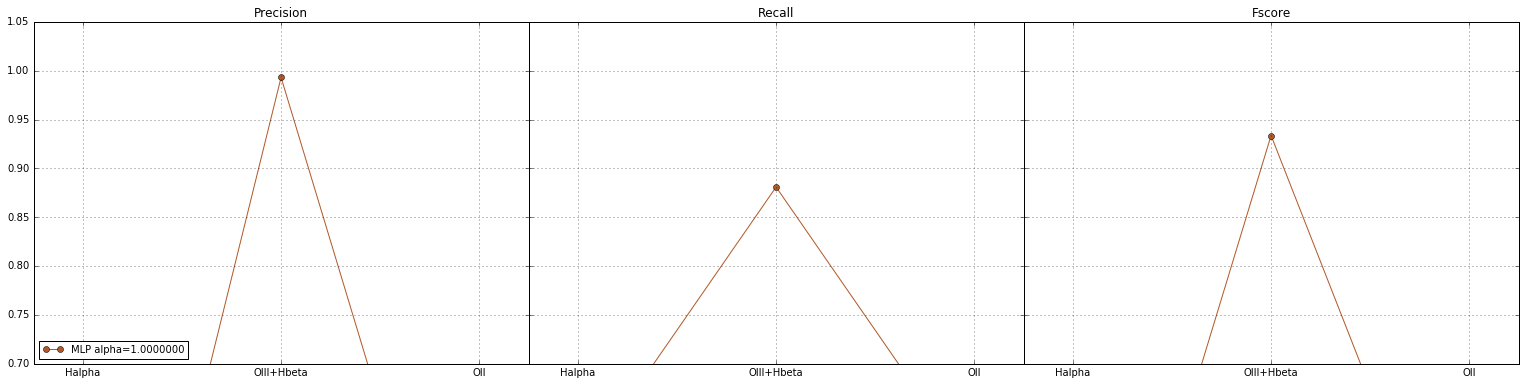

In [80]:
# First validate the training set

classifiers = {}

import numpy as np

nalpha = 10

a_arr = np.logspace(-2,0,num=nalpha)

for aa in range(nalpha):
    alpha = a_arr[aa]
    print alpha
    classifiers['MLP alpha=%.7f'%(alpha)] = MLPClassifier(solver='lbfgs',
                                            hidden_layer_sizes=(nfeat, nfeat),
                                            activation='logistic', alpha=alpha,
                                                         random_state=1, tol=1e-4, max_iter=1000)
        


cnum = [0, 1, 2]
#ctype = ['Halpha', 'OIII', 'Hbeta','OII']
ctype = ['Halpha', 'OIII+Hbeta','OII']
nclass = 1
mlcolors = plt.cm.Paired(np.linspace(0,1,nalpha))

#plt.figure('summary')

plt.figure(figname)
plt.rcParams['figure.figsize'] = 15, 10
gs = gsc.GridSpec(1,3)
gs.update(wspace=0.0, right=1.5,top=0.6)

gs2 = gsc.GridSpec(1,3)
gs2.update(wspace=0.0, right=1.5,top=0.6)


for index in range(nalpha):
    alpha = a_arr[index]
    name = 'MLP alpha=%.7f'%(alpha)
    classifier = classifiers[name]
    print name
    classifier.fit(Traindata, training_class)
    y_train = classifier.predict(Traindata)
    y_test  = classifier.predict(Testdata)
    
    precision, recall, fscore, support = metrics.precision_recall_fscore_support(training_class, 
                                                                                 y_train, labels=ctype)
    color = mlcolors[index]
    summary_performance_plot(index,precision, recall, fscore, color, cnum, ctype, name,  gs, figname='Training', ylim=[0.7,1.05])
    
    precision, recall, fscore, support = metrics.precision_recall_fscore_support(validate_class, 
                                                                                 y_test, labels=ctype)
    color = mlcolors[index]
    summary_performance_plot(index,precision, recall, fscore, color, cnum, ctype, name,  gs, figname='Validation', ylim=[0.7,1.05])
    



Normalized confusion matrix
[[ 0.64705882  0.17647059  0.17647059]
 [ 0.29411765  0.64705882  0.05882353]
 [ 0.12320329  0.04517454  0.83162218]]
Normalized confusion matrix
[[ 0.64705882  0.17647059  0.17647059]
 [ 0.29411765  0.64705882  0.05882353]
 [ 0.12320329  0.04517454  0.83162218]]
Normalized confusion matrix
[[ 0.64705882  0.17647059  0.17647059]
 [ 0.29411765  0.64705882  0.05882353]
 [ 0.12320329  0.04517454  0.83162218]]


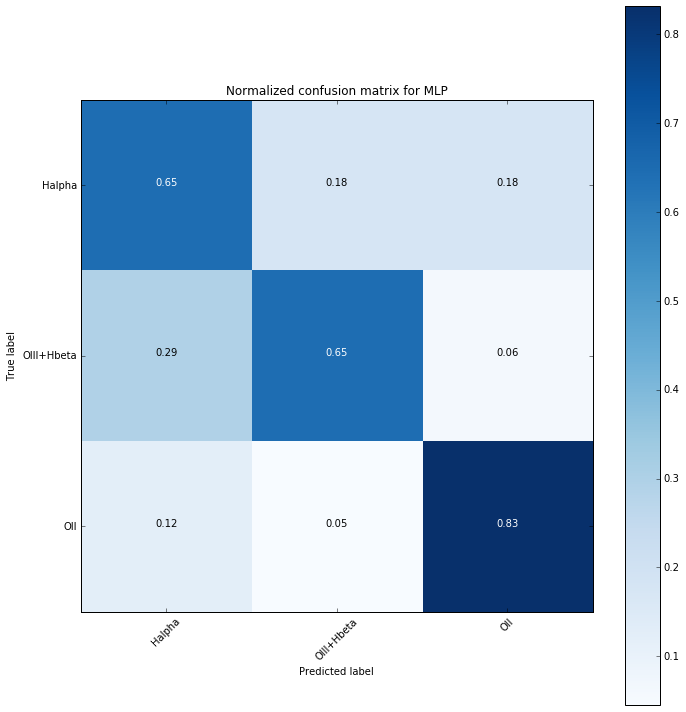

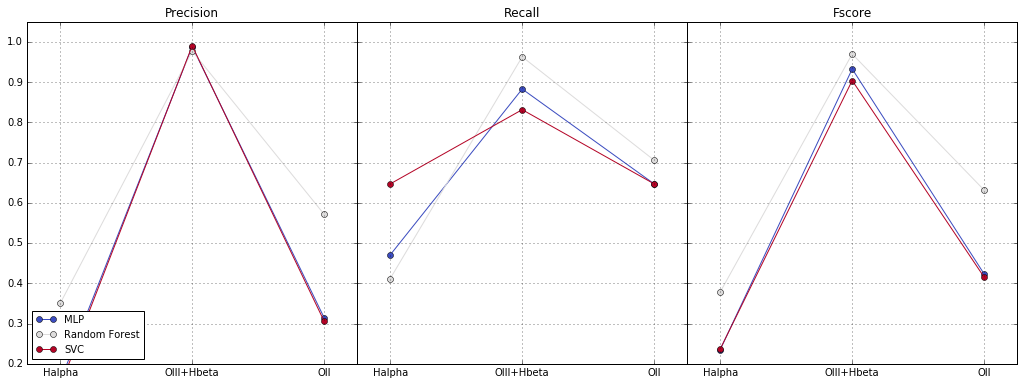

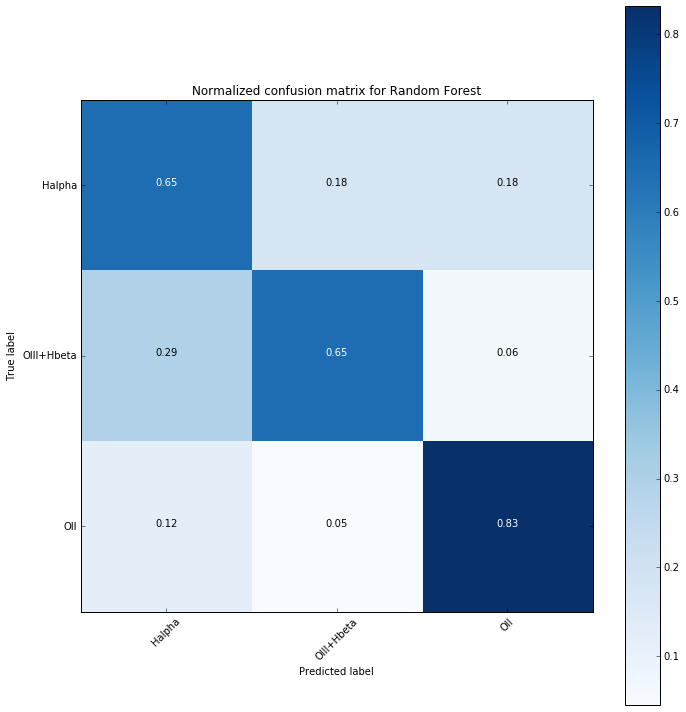

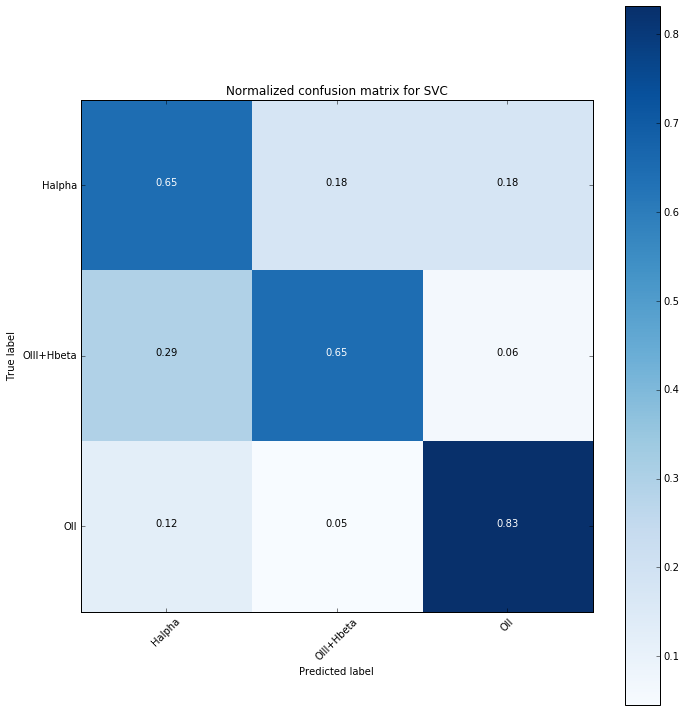

In [68]:
#classifier = MLPClassifier(solver='lbfgs')
C = 1.0
kernel = 1.0 * RBF([1.0,1.0,1.0,1.0,1.0,1.0]) # for GPC

classifiers = { 'MLP'                       : MLPClassifier(solver='lbfgs',
                                                            hidden_layer_sizes=(nfeat, nfeat),
                                                           activation='logistic', alpha=0.0774, random_state=1,
                                                           tol=1e-6, max_iter=1000) ,
                    'Random Forest'             : RandomForestClassifier(n_estimators=50),
                    'SVC'                       : svm.SVC(),
#                    'L1 logistic'               : LogisticRegression(C=C, penalty='l1'),
#                    'L2 logistic (OvR)'         : LogisticRegression(C=C, penalty='l2'),
#                    'L2 logistic (Multinomial)' : LogisticRegression(C=C, solver='lbfgs',multi_class='multinomial')
#                    'GPC'                       : GaussianProcessClassifier(kernel)
                    }

nclass = float(len(classifiers))
mlcolors = plt.cm.coolwarm(np.linspace(0,1,nclass))
plt.rcParams['figure.figsize'] = 10, 10

plt.figure(1)

cnum = [0, 1, 2]
ctype = ['Halpha', 'OIII+Hbeta','OII']

for index, (name, classifier) in enumerate(classifiers.items()):

    classifier.fit(Traindata, training_class)
    y_pred = classifier.predict(Testdata)

    scoring = ['precision_macro', 'recall_macro', 'f1_macro']
    #scores = cross_validate(classifier, Traindata, training_class, scoring=scoring,
    #         cv=5, return_train_score=True)
    #print scores
    
    #print 'Metrics for %s'%name
    #print metrics.classification_report(validate_class, y_pred, labels=ctype, )
    precision, recall, fscore, support = metrics.precision_recall_fscore_support(validate_class, y_pred, labels=ctype)
#    success_rate = np.zeros(3)

#    for i in cnum:
#        mm = np.where((real_val == i) & (real_val == pred_val))[0]
#        success_rate[i] = np.float(len(mm)) / (len(np.where(real_val == i)[0]))

    #plt.figure('m1%d'%index)
    #cnf_matrix = confusion_matrix(validate_class, y_pred)
    #plot_confusion_matrix(cnf_matrix, classes=ctype,
    #                  title='Confusion matrix for %s, without normalization'%name, cmap = plt.cm.Blues)

# Plot normalized confusion matrix
    plt.figure('m2%d'%index)
    plot_confusion_matrix(cnf_matrix, classes=ctype, normalize=True,
                      title='Normalized confusion matrix for %s'%name)
    
    color = mlcolors[index]
    figname = 'comp'
    plt.figure(figname)
    summary_performance_plot(precision, recall, fscore, color, cnum, ctype, name,  gs, figname=figname, ylim=[0.2,1.05])


In [ ]:
# Pipelining: chaining a PCA and a logistic regression
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

logistic = linear_model.LogisticRegression()

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])



# Plot the PCA spectrum
pca.fit(Traindata)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

# Prediction
n_components = [20, 40, 64]
Cs = np.logspace(-4, 4, 3)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(Traindata, training_class)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(validate_class, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=ctype,
                      title='Confusion matrix, without normalization', cmap = plt.cm.Blues)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=ctype, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

